# **Análisis estadístico del corpus**

El corpus construido a partir del proceso de extracción contiene, para cada documento, la siguiente información básica:

*   Autor
*   Título
*   Texto completo del poema


Con el objetivo de realizar un análisis estadístico más detallado y enriquecer el corpus, se incorporan nuevos:

*   Número de Likes
*   Número de versos
*   Número de estrofas

Estos atributos permiten caracterizar cuantitativamente los poemas y explorar posibles patrones entre estructura poética y percepción del público.

Para ello se sigue el siguiente esquema.

1.   Carga y visualización inicial del corpus
2.   Depuración del corpus
3.   Limpieza y normalización de metadatos








# **Metadatos**


## Carga y visualización inicial del corpus

En esta sección visualizamos como se enuentran nuestros datos, lo cual nos ayuda a posteriormente implementar estrategías de extracción de características.

In [1]:
# Lectura del archivo
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LC/poemas_completo.csv')

In [3]:
# Dataframe
data.head(5)

,autor,titulo,poemas
0,A Isa Ahmad Ibn Muhammad Ibn Qadim,Panegírico a Al-Muzaffar,Poema siguiente\n\r\n¡Que Dios te muestre lo q...
1,A Isa Ahmad Ibn Muhammad Ibn Qadim,Poema que escribió a un poeta que no le agradaba,"Poema siguiente\n\r\nLeona soy, pero no me agr..."
2,Abel Alarcón,La abadesa,Poema siguiente\n\r\nPor el jardín paseaba la ...
3,Abel Alarcón,Pascua,"Poema siguiente\n\r\nElevó, adusto, el sacerdo..."
4,Abel G. Fagundo,Extraña salvaje,Poema siguiente\n\r\nYo tengo una extraña que ...


In [4]:
data.shape

(13518, 3)

A continuación vemos el ejemplo de un poema, conserva elementos como \n, \r, que contienen la estructura del poema (versos y estrofas). Además, se observa que hay ruido en común al inicio y al final del texto, siendo uno de los párrafos finales donde se enuentra la cantidad de likes.

In [5]:
data['poemas'][712]

'Poema siguiente\n\r\nMe gusta verte desde lejos\r\nacecharte discretamente\r\nprovocarte\r\nReinventar cada encuentro\r\nadivinarte\n\r\nSigilosa encenderte\r\ndisfrutar el placer\r\nde enamorarte\n\r\ny como leona\r\nechada\r\nverte llegar\r\na mí\r\nmuy lentamente\n\n ME GUSTA 5 \n\n\n\nVer métrica Poema siguiente\xa0\n\xa0Volver a Ana María Ardón'

In [6]:
print(data['poemas'][712])

Poema siguiente

Me gusta verte desde lejos
acecharte discretamente
provocarte
Reinventar cada encuentro
adivinarte

Sigilosa encenderte
disfrutar el placer
de enamorarte

y como leona
echada
verte llegar
a mí
muy lentamente

 ME GUSTA 5 



Ver métrica Poema siguiente 
 Volver a Ana María Ardón


## Depuración del corpus


### Eliminación de registros duplicados.

Filtramos los datos que puedan estar duplicados por autor y por título, en caso de coincidencias se eliminan.

In [7]:
duplicados = data[data.duplicated(subset = ['autor', 'titulo'])]
duplicados.shape

(308, 3)

In [8]:
data.drop_duplicates(subset=['autor', 'titulo'], inplace=True)
data.shape

(13210, 3)

Se encontraron 308 registros duplicados, que al ser eliminados nos deja con un total de 13 210 registros.

### Eliminación de registros con valores nulos o incompletos.

Verificamos el total de elmentos nulos en los registros, en este caso no se encontó ninguno.

In [9]:
data.isnull().sum()

,0
autor,0
titulo,0
poemas,0


## Limpieza y normalización de metadatos

Se realizan dos puntos de extracción.

*   Extracción de likes.
*   Extracción y limpieza para versos y estrofas.



In [10]:
# Librerias
import re
import numpy as np

### Extracción de likes

Usando expresiones regulares (regex) y con la identificación del contenido se estructura le expresión `"ME GUSTA\s*(\d+)"` con el método `search` de `re`, el cual busca una coincidencia en cualquier parte de la cadena de texto y devuelve un objeto si encuentra algo.

In [11]:
# Fución para la extracción de likes
def likes(texto):
  likes = re.search(r"ME GUSTA\s*(\d+)", texto)
  return int(likes.group(1)) if likes else 0


data['likes'] = data['poemas'].apply(likes)


In [12]:
data.head(3)

,autor,titulo,poemas,likes
0,A Isa Ahmad Ibn Muhammad Ibn Qadim,Panegírico a Al-Muzaffar,Poema siguiente\n\r\n¡Que Dios te muestre lo q...,2
1,A Isa Ahmad Ibn Muhammad Ibn Qadim,Poema que escribió a un poeta que no le agradaba,"Poema siguiente\n\r\nLeona soy, pero no me agr...",5
2,Abel Alarcón,La abadesa,Poema siguiente\n\r\nPor el jardín paseaba la ...,7


### Extracción y limpieza para versos y estrofas

A partir de visualizar la estructura de los poemas

```
ruido ruido siguiente
estrofras
estrofras
estrofas
ruido ruido ME GUSTA N
ruido..
```
Es necesaio eliminar este ruido para realizar el conteo de versos y estrofas. Además de realizar una normalización de elementos de saltos de línea.

Con el método `sub` se elimanan estos fragmentos con las regex propuestas como `"^.*?siguiente\n*(\r\n)*"` y `"\n+\s*ME\s+GUSTA\s+\d+.*$"`. Las cuales identifican el ruido iniccial y el final en cada poema.

Finalmente, para identificar los saltos se realiza un remplazo en:


*   '\n\r\n' → '\n\n'
*   '\r\n' → '\n'


In [13]:
def eliminar_ruido(texto):
    texto = texto.replace('\n\r\n', '\n\n').replace('\r\n', '\n')
    texto = re.sub(r"^.*?siguiente\n*(\r\n)*", "", texto, flags=re.IGNORECASE | re.DOTALL)
    texto = re.sub(r"\n+\s*ME\s+GUSTA\s+\d+.*$", "", texto, flags=re.IGNORECASE | re.DOTALL)
    return texto

data['texto'] = data['poemas'].apply(eliminar_ruido)

Corroboramos la efectividad con el primer ejemplo, se elimina el ruido y además no elimina las palabras como "Me gusta" que aparecen en los poemas.

In [14]:
print(data['texto'][712])

Me gusta verte desde lejos
acecharte discretamente
provocarte
Reinventar cada encuentro
adivinarte

Sigilosa encenderte
disfrutar el placer
de enamorarte

y como leona
echada
verte llegar
a mí
muy lentamente


**Conteo de versos y estrofas**

Una vez limpio el texto se realiza el conteo de  versos y estrofas,

In [15]:
def estrofas_verso(texto):
  nestrofas = texto.count('\n\n')
  texto = texto.replace('\n\n', '\n')
  nversos = texto.count('\n')

  return nestrofas + 1, nversos + 1

data[['estrofas', 'versos']] = data['texto'].apply(estrofas_verso).apply(pd.Series)

### Resultado
Finalmente, obtenemos un dataframe con mayores características relevantes

In [16]:
data.head(3)

,autor,titulo,poemas,likes,texto,estrofas,versos
0,A Isa Ahmad Ibn Muhammad Ibn Qadim,Panegírico a Al-Muzaffar,Poema siguiente\n\r\n¡Que Dios te muestre lo q...,2,¡Que Dios te muestre lo que deseas\ny que no c...,1,14
1,A Isa Ahmad Ibn Muhammad Ibn Qadim,Poema que escribió a un poeta que no le agradaba,"Poema siguiente\n\r\nLeona soy, pero no me agr...",5,"Leona soy, pero no me agradaron jamás\nlos cub...",1,5
2,Abel Alarcón,La abadesa,Poema siguiente\n\r\nPor el jardín paseaba la ...,7,Por el jardín paseaba la Abadesa\nLeyendo una ...,4,14


# Estadística para metadatos

In [17]:
data['estrofas'] = pd.to_numeric(data['estrofas'], errors='coerce')
data['versos'] = pd.to_numeric(data['versos'], errors='coerce')
data['likes'] = pd.to_numeric(data['likes'], errors='coerce')

## Descripción de los datos

Podemos observar en las medidas de tendencia central que los datos contienen desviaciones grandes, ya que la media no coincide con la mediana. Esto quiere decir que tenemos valores atípicos que modifican la media.

Además, los valores máximos indican claramente la  presencia de este tipo de datos, ya que hasta el 75% de los datos hay una brecha muy grande.

In [18]:
print(data[['estrofas', 'versos', 'likes']].describe())

           estrofas        versos         likes
count  13210.000000  13210.000000  13210.000000
mean       4.858668     28.198562      5.858819
std        8.400694     40.031098      6.822117
min        1.000000      1.000000      0.000000
25%        1.000000     13.000000      2.000000
50%        3.000000     18.000000      4.000000
75%        5.000000     31.000000      7.000000
max      284.000000   1964.000000    216.000000


Para visualizar mejor el comportamiento se muestran los siguientes gráficos.

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns



## Frecuencias

Las dos gráficas de de frecuencias para versos y estrofas nos muestran como los poemas con versos entre 1-30 versos y 1-5 estrofas son más frerecuentes que el resto.

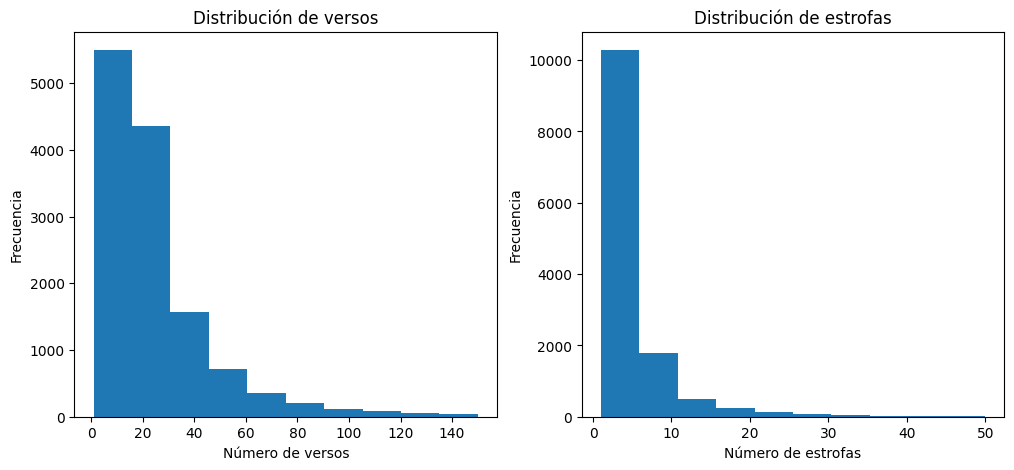

In [20]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.hist(data['versos'], bins=10, range=(1,150))
plt.title("Distribución de versos")
plt.xlabel("Número de versos")
plt.ylabel("Frecuencia")

plt.subplot(1, 2, 2)
plt.hist(data['estrofas'], bins=10,range=(1,50))
plt.title("Distribución de estrofas")
plt.xlabel("Número de estrofas")
plt.ylabel("Frecuencia")
plt.show()

## Boxplot
Muestra como hay gran cantidad de valores atípicos, tanto para versos como para estrofas.

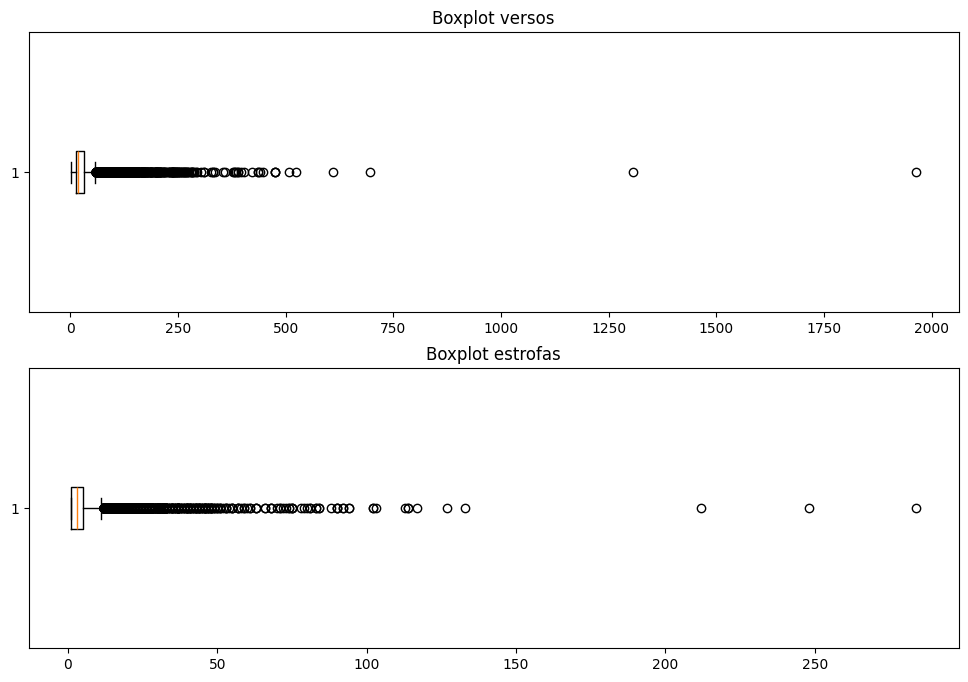

In [21]:
plt.figure(figsize=(12,8))

plt.subplot(2, 1, 1)
plt.boxplot(data['versos'], orientation = 'horizontal')
plt.title("Boxplot versos")

plt.subplot(2, 1, 2)
plt.boxplot(data['estrofas'], orientation = 'horizontal')
plt.title("Boxplot estrofas")

plt.show()

## Gráficos de disipersión
Estos gráficos nos muestran como se distibuyen  los versos y estrofas debido a la cantidad de likes. Con lo que podemos observar que los poemas  más populares tienden a ser cortos.

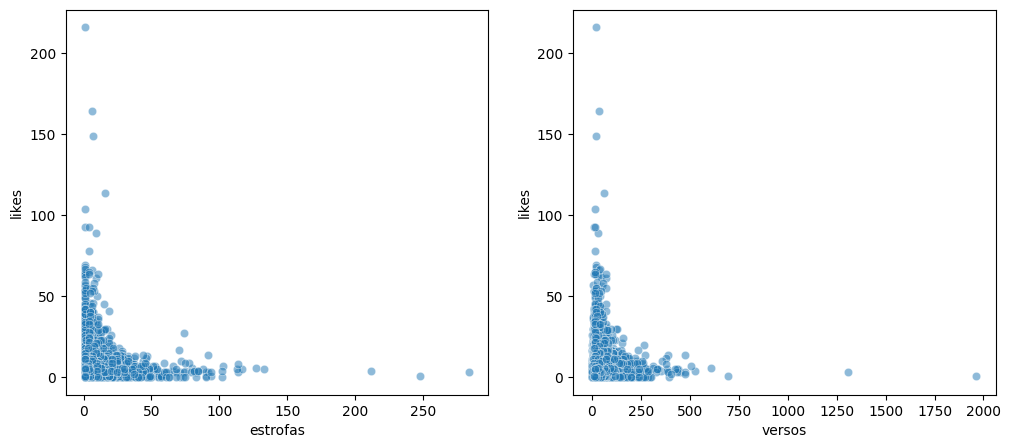

In [22]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=data, x='estrofas', y='likes', alpha = 0.5)

plt.subplot(1, 2, 2)
sns.scatterplot(data=data, x='versos', y='likes', alpha = 0.5)

plt.show()

# Riqueza léxica

Para calcular la riqueza léxca del corpus y de cada poema en necesario obtener las palabras únicas totales e individuales.





## Nivel documento

Se debe realizar una limpiez de los carácteres que no sean texto (saltos de línea, símbolos de puntuación, etc.) y posteriormente realizar el conteo de la siguiente forma:



1.   Limpieza de simbolos no textuales.
2.   Tokenización por palabra.
3.   Conteo de palabras.
4.   Conteo de palabras únicas.
5.   Cálculo de la riqueza léxica.

In [23]:
def limpiar_caracteres(texto: str) -> str:
    """
    Limpia y normaliza el texto eliminando caracteres no alfanuméricos.

    Args:
        texto: Texto a limpiar

    Returns:
        Texto limpio en minúsculas
    """
    if not isinstance(texto, str):
        return ""

    texto = re.sub(r"[^\w\s]", " ", texto)

    texto = re.sub(r"\s+", " ", texto)

    return texto.strip().lower()

def tokenizar(texto: str) -> list[str]:
    """
    Divide el texto en tokens (palabras).

    Args:
        texto: Texto a tokenizar

    Returns:
        Lista de tokens
    """
    if not isinstance(texto, str):
        return []

    return texto.split()

def contar_tokens(texto: str) -> int:
    """
    Cuenta el número de tokens en un texto.

    Args:
        texto: Texto a analizar

    Returns:
        Número de tokens
    """
    tokens = tokenizar(texto)
    return len(tokens)

def palabras_unicas(texto: str) -> int:
    """
    Calcula el número de palabras únicas en un texto.

    Args:
        texto: Texto a analizar

    Returns:
        Número de palabras únicas
    """
    tokens = tokenizar(texto)
    return len(set(tokens))

def riqueza_lexica(palabras_unicas: int, total_palabras: int) -> float:
    """
    Calcula la riqueza léxica.

    Args:
        palabras_unicas: Número de palabras únicas
        total_palabras: Número total de palabras

    Returns:
        Riqueza léxica (0.0 a 1.0)
    """
    if total_palabras == 0:
        return 0.0

    return palabras_unicas / total_palabras


def procesar_dataframe(data: pd.DataFrame, columna_texto: str = 'texto') -> pd.DataFrame:
    """
    Procesa un DataFrame aplicando análisis de texto.

    Args:
        data: DataFrame a procesar
        columna_texto: Nombre de la columna con el texto

    Returns:
        DataFrame con columnas adicionales de análisis
    """
    df = data.copy()

    # Limpiar texto
    df[columna_texto] = df[columna_texto].apply(limpiar_caracteres)

    # Calcular métricas
    df['palabras'] = df[columna_texto].apply(contar_tokens)
    df['palabras_unicas'] = df[columna_texto].apply(palabras_unicas)
    df['riqueza'] = df.apply(
        lambda x: riqueza_lexica(x['palabras_unicas'], x['palabras']),
        axis=1
    )

    return df

In [24]:
data = procesar_dataframe(data)

In [25]:
data.head(5)

,autor,titulo,poemas,likes,texto,estrofas,versos,palabras,palabras_unicas,riqueza
0,A Isa Ahmad Ibn Muhammad Ibn Qadim,Panegírico a Al-Muzaffar,Poema siguiente\n\r\n¡Que Dios te muestre lo q...,2,que dios te muestre lo que deseas y que no ces...,1,14,99,72,0.727273
1,A Isa Ahmad Ibn Muhammad Ibn Qadim,Poema que escribió a un poeta que no le agradaba,"Poema siguiente\n\r\nLeona soy, pero no me agr...",5,leona soy pero no me agradaron jamás los cubil...,1,5,31,25,0.806452
2,Abel Alarcón,La abadesa,Poema siguiente\n\r\nPor el jardín paseaba la ...,7,por el jardín paseaba la abadesa leyendo una o...,4,14,87,60,0.689655
3,Abel Alarcón,Pascua,"Poema siguiente\n\r\nElevó, adusto, el sacerdo...",4,elevó adusto el sacerdote anciano de ácimo pan...,4,14,88,66,0.750000
4,Abel G. Fagundo,Extraña salvaje,Poema siguiente\n\r\nYo tengo una extraña que ...,4,yo tengo una extraña que nació salvaje de su l...,3,13,81,64,0.790123


### Visualización

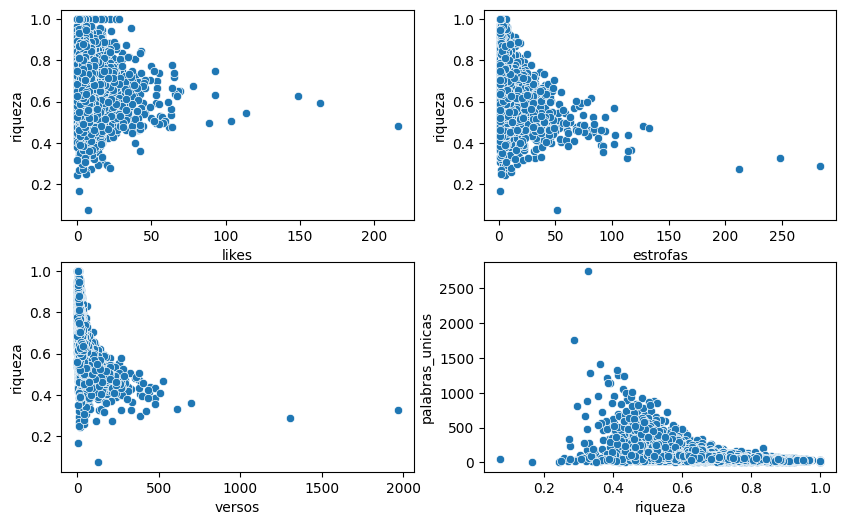

In [26]:
plt.figure(figsize=(10,6))
plt.subplot(2, 2, 1)
sns.scatterplot(data=data, x='likes', y='riqueza')

plt.subplot(2, 2, 2)
sns.scatterplot(data=data, x='estrofas', y='riqueza')

plt.subplot(2, 2, 3)
sns.scatterplot(data=data, x='versos', y='riqueza')

plt.subplot(2, 2, 4)
sns.scatterplot(data=data, x='riqueza', y='palabras_unicas')

plt.show()

## Nivel curpus

Al tener un texto limpio el cual fue realizado en el proceso anterior el cálculo de palabras únicas y totales se facilita. Además, con el uso de la libreria `nltk` podemos eliminar stop words del corpus.

In [27]:
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [88]:
tokens_totales = (data['texto'].apply(word_tokenize).explode().tolist())
tokens_unicos= list(set(tokens_totales))

In [89]:
print('Tokens totales: ', len(tokens_totales))
print('Tokens únicos: ', len(tokens_unicos))

Tokens totales:  2126634
Tokens únicos:  90530


**Nota:** Utilizar `word_tokenize` o la función creada `tokenizar()` genera el mismo resultado, se realiza con el fin de mostrar que hay distintos caminos para la tokenización.

### Frecuencia de palabras con stop words

<Axes: title={'center': 'Frecuencia de palabras totales'}, xlabel='Samples', ylabel='Counts'>

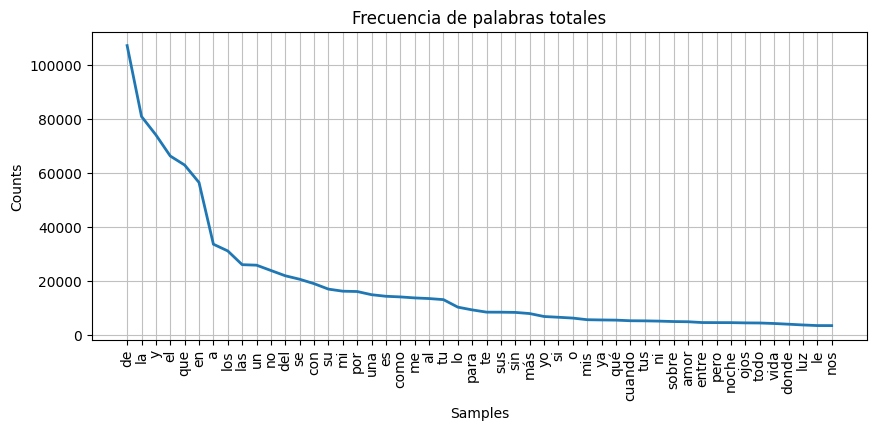

In [144]:
f_total = nltk.FreqDist(tokens_totales)
plt.figure(figsize=(10,4))
f_total.plot(50,cumulative=False, title='Frecuencia de palabras totales')

### Frecuencia de palabras sin stop words utilizando nltk

In [30]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [123]:
stop_es =  stopwords.words('spanish')
no_stop = [token for token in tokens_totales if token not in stop_es]

<Axes: title={'center': 'Frecuancia de palabras sin stopwords'}, xlabel='Samples', ylabel='Counts'>

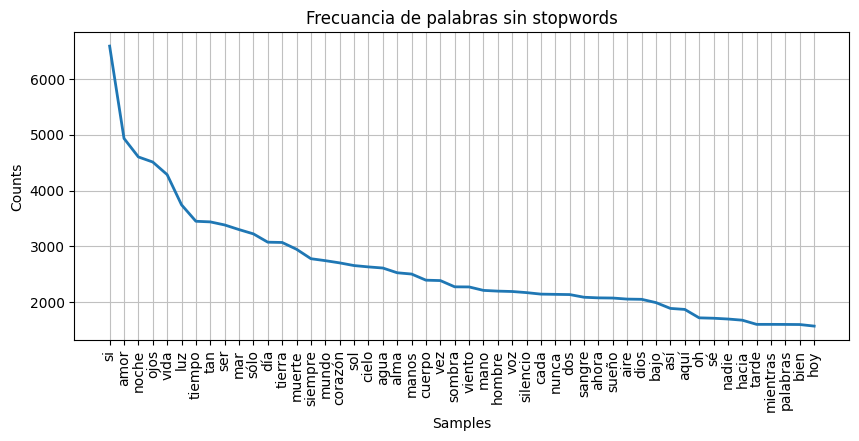

In [145]:
f_nostp = nltk.FreqDist(no_stop)
plt.figure(figsize=(10,4))
f_nostp.plot(50,cumulative=False, title = 'Frecuancia de palabras sin stopwords')

### Frecuencia de palabras con Stemming

Con ayuda de la  libreria nltk se aplica el stemming a los tokens sin stopwords

In [33]:
from nltk.stem import SnowballStemmer

In [34]:
stemmer_es =  SnowballStemmer('spanish')
stemmed_tokens = [stemmer_es.stem(word) for word in no_stop]

<Axes: title={'center': 'Frecuancia de palabras con stemming'}, xlabel='Samples', ylabel='Counts'>

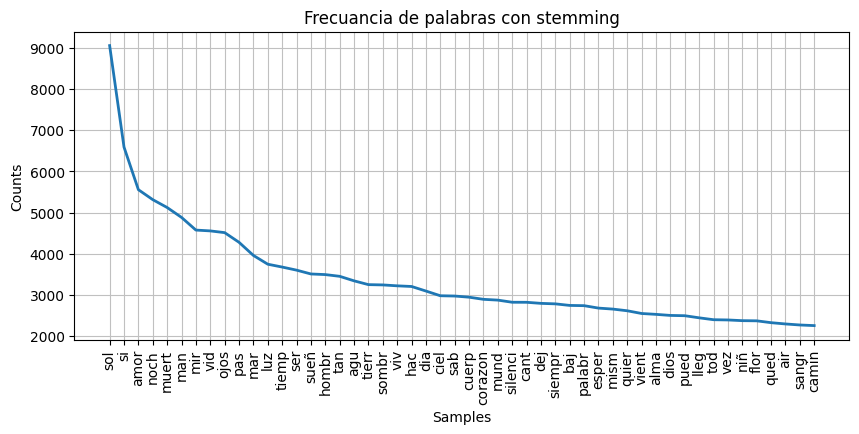

In [146]:
f_stemmed = nltk.FreqDist(stemmed_tokens)
plt.figure(figsize=(10,4))
f_stemmed.plot(50,cumulative=False, title = 'Frecuancia de palabras con stemming')

### Frecuancia de palabras con lematización

Para realizar la lematización del texto es necesaria la libreria `sacy` ya que nltk no cuenta con lematizador en español.

El total de palabras es muy grande, por lo que no puede ser procesado completamente, por lo cual se implementa una función para dividir el total de palabras en chunks que puedan ser procesables, ya que solo se admiten hasata 100 000.


In [36]:
import spacy
!python3 -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 74.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [84]:
nlp_es = spacy.load("es_core_news_sm")

In [118]:
def dividir_texto_en_chunks(texto: list[str], max_length: int = 900000) -> list[str]:
    """
    Divide el texto en fragmentos manejables.

    Args:
        texto: TLista de palabras completa
        max_length: Tamaño máximo de cada fragmento

    Returns:
        Lista de fragmentos de texto
    """
    texto = ' '.join(texto)
    chunks = []
    inicio = 0

    while inicio < len(texto):
        # Obtener fragmento
        fin = inicio + max_length

        # Si no es el último fragmento, buscar un espacio para cortar
        if fin < len(texto):
            # Buscar el último espacio antes del límite
            ultimo_espacio = texto.rfind(' ', inicio, fin)
            if ultimo_espacio > inicio:
                fin = ultimo_espacio

        chunks.append(texto[inicio:fin])
        inicio = fin

    return chunks

Una vez definifa la función de dividir el texto se procede a aplicar la lematización en cada chunk con la función lematizar.

In [119]:
def lematizar(texto: list[str], chunk_size: int = 900000, mostrar_progreso: bool = True) -> list[str]:
    """
    Lematiza textos largos procesándolos en fragmentos.

    Args:
        texto: Texto a lematizar
        chunk_size: Tamaño de cada fragmento
        mostrar_progreso: Si True, muestra barra de progreso

    Returns:
        Lista de lemas procesados
    """

    # Dividir en chunks
    chunks = dividir_texto_en_chunks(texto, chunk_size)

    print(f"Procesando texto de {len(texto):,} caracteres en {len(chunks)} fragmentos")

    todos_los_lemas = []

    # Procesar cada chunk
    for i, chunk in enumerate(chunks, 1):
        if mostrar_progreso:
            print(f"Procesando fragmento {i}/{len(chunks)}")
        doc = nlp_es(chunk)

        for token in doc:
            # Aplicar filtros
            if token.is_space:
                continue

            todos_los_lemas.append(token.lemma_.lower())

    if mostrar_progreso:
        print(f"\nProcesamiento completado: {len(todos_los_lemas):,} lemas extraídos")

    return todos_los_lemas

In [125]:
lemas = lematizar(no_stop)

Procesando texto de 1,102,618 caracteres en 9 fragmentos
Procesando fragmento 1/9
Procesando fragmento 2/9
Procesando fragmento 3/9
Procesando fragmento 4/9
Procesando fragmento 5/9
Procesando fragmento 6/9
Procesando fragmento 7/9
Procesando fragmento 8/9
Procesando fragmento 9/9

Procesamiento completado: 1,102,926 lemas extraídos


<Axes: title={'center': 'Frecuancia de palabras con lematizado'}, xlabel='Samples', ylabel='Counts'>

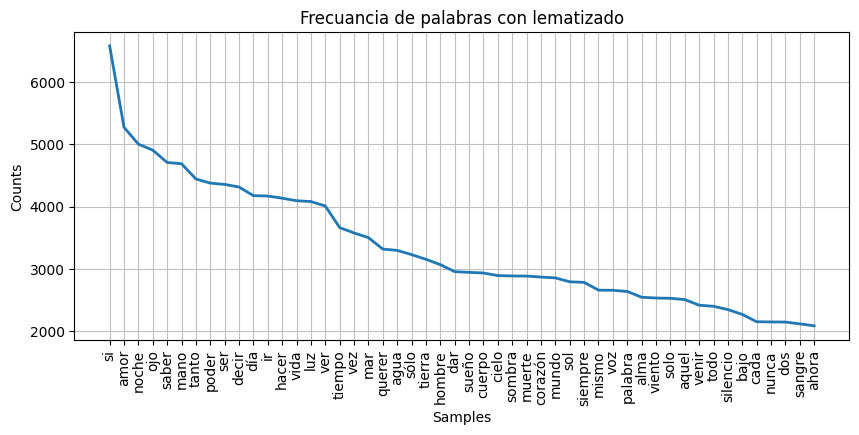

In [147]:
f_lemated = nltk.FreqDist(lemas)
plt.figure(figsize=(10,4))
f_lemated.plot(50,cumulative=False, title = 'Frecuancia de palabras con lematizado')

### Tabla comparativa del análisis de frecuencias de los top 15 términos más frecuentes

In [148]:
comunes = 15
# Definimos un ancho para cada columna
w = 22

print("=" * (w * 5))
print(f"{'':<{w}} {'Con Stopword':<{w}} {'Sin Stopwords':<{w}} {'Stemming':<{w}} {'Lematizado':<{w}}")
print("=" * (w * 5))

l1 = f_total.most_common(comunes)
l2 = f_nostp.most_common(comunes)
l3 = f_stemmed.most_common(comunes)
l4 = f_lemated.most_common(comunes)

for i in range(comunes):
    row = f"{str(i+1):<{w}} {str(l1[i]):<{w}} {str(l2[i]):<{w}} {str(l3[i]):<{w}} {str(l4[i]):<{w}}"
    print(row)

                       Con Stopword           Sin Stopwords          Stemming               Lematizado            
1                      ('de', 106998)         ('si', 6589)           ('sol', 9054)          ('si', 6589)          
2                      ('la', 80801)          ('amor', 4934)         ('si', 6589)           ('amor', 5276)        
3                      ('y', 73993)           ('noche', 4602)        ('amor', 5554)         ('noche', 5005)       
4                      ('el', 66190)          ('ojos', 4511)         ('noch', 5312)         ('ojo', 4908)         
5                      ('que', 62847)         ('vida', 4285)         ('muert', 5121)        ('saber', 4710)       
6                      ('en', 56399)          ('luz', 3744)          ('man', 4881)          ('mano', 4689)        
7                      ('a', 33587)           ('tiempo', 3449)       ('mir', 4573)          ('tanto', 4444)       
8                      ('los', 31101)         ('tan', 3438)          ('vid', 455

# Nube de palabras
La nube de palabras nos muestra cuales de ellas son más relevantes en el corpus. Para  realizar la visualización, se aplica la eliminación de stopwords y los términos de más alta frecuencia.

In [149]:
from wordcloud import WordCloud, STOPWORDS

## Nube de palabras sin storpwords

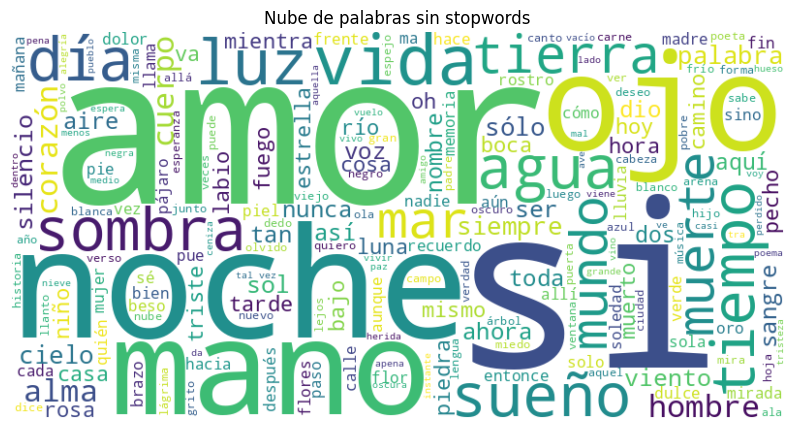

In [150]:
text = " ".join(no_stop)
wordclaude = WordCloud(stopwords=STOPWORDS, background_color="white", width = 800, height= 400).generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordclaude, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras sin stopwords")
plt.show()

## Nube de palabras sin términos de alta frecuencia

In [155]:
alta_frecuencia = f_total.most_common(39)
mostcomon = [token[0] for token in alta_frecuencia]
no_fecuecia_alta = [token for token in tokens_totales if token not in mostcomon]

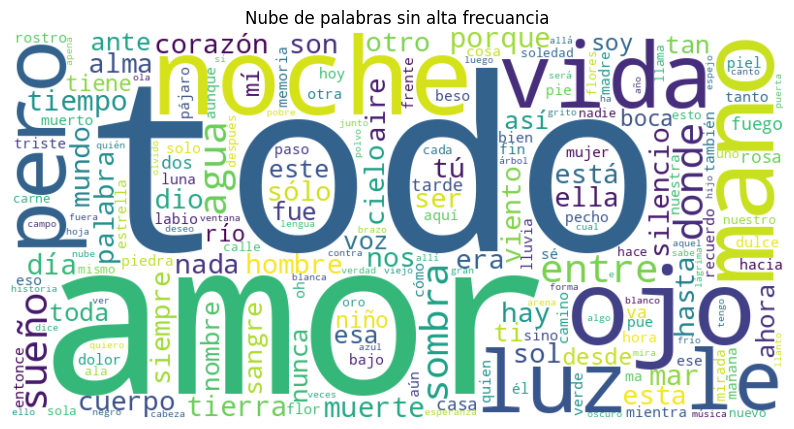

In [157]:
text = " ".join(no_fecuecia_alta)
wordclaude = WordCloud(stopwords=STOPWORDS, background_color="white", width = 800, height= 400).generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordclaude, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras sin alta frecuancia")
plt.show()

La elección de los primeros 39 términos de más alta frecuencia se basa en la observación de la tabla comparativa de frecuancias y de los gráficos de frecuencia. Se han elegido los 39 términos debido a que se muestra la aparición de stopword y además en el término 40 se habla de una palabra con alta fecuancia común en todos los métodos aplicados.

# Conclusiones

El análisis realizado muestra como incorporar metadatos presentes en la extracción de los documentos a nuestro análisis.

Además, se muesstra que este tipo de textos tiene una alta dispersión, lo cual se puede observar en los gráficos de distribuciones y en como varía la media ded las muestras.

Finalmente, los análisis de frecuencias nos permiten observar cuales son los posibles temas y términos comúnes utilizados en todos los poemas.